In [ ]:
# 최적화된 서비스 설계 (DB에서 URL 형태로 관리되는 이미지)
# 1. 서비스 흐름 최적화
# 1) 클라이언트 요청
# 클라이언트는 인물 이미지와 의류 이미지를 업로드.
# 서버는 DB 또는 JSON 파일에서 관련 데이터를 검색하고, 이미지 URL을 가져옴.
# 2) FastAPI 서버
# 이미지 URL을 받아 메모리 또는 임시 디렉토리로 로드.
# 이미지를 리사이즈 및 전처리.
# 처리된 이미지를 Virtual Try-On 모델에 입력.
# 3) Virtual Try-On 모델
# 모델이 입력 데이터를 기반으로 결과 이미지를 생성.
# 생성된 이미지를 디스크에 저장 또는 URL로 변환.
# 4) 결과 반환
# 클라이언트에 결과 이미지의 URL 또는 파일 경로를 반환.
# 결과 이미지가 더 이상 필요 없다면, 임시 디렉토리에서 삭제.

### 클라이언트에서 url 가져옴

In [ ]:
import json

def get_image_urls_from_db(db_path, product_id):
    """
    JSON DB에서 product_id에 해당하는 이미지 URL을 가져옵니다.
    """
    with open(db_path, "r") as f:
        db_data = json.load(f)

    for category, products in db_data.items():
        for product in products:
            if product["product_info"]["id"] == product_id:
                # image_url 가져오기
                style_analysis = product.get("style_analysis", [])
                if style_analysis:
                    image_url = style_analysis[0].get("image_url")  # 첫 번째 URL 사용
                    if image_url:
                        return image_url
    return None  # 해당하는 URL이 없을 경우 None 반환

# Example usage
db_path = r"crawling/bottom.json"
product_id = 1  # 클라이언트에서 제공한 ID
image_url = get_image_urls_from_db(db_path, product_id)

if image_url:
    print(f"Image URL: {image_url}")
else:
    print("Image URL not found.")


Image URL: https://image-cdn.trenbe.com/productmain/1729680166303-a13bf7df-7ef9-4dbd-90ae-63d3039dfece.jpeg


### FASTAPI 코드 가져옴

In [ ]:
from fastapi import FastAPI, HTTPException
import requests
from PIL import Image, ImageOps
from io import BytesIO
import os
import json

app = FastAPI()

TEMP_DIR = "temp_images"
os.makedirs(TEMP_DIR, exist_ok=True)

def resize_with_aspect_ratio(image, target_width, target_height):
    aspect_ratio = image.width / image.height
    target_aspect_ratio = target_width / target_height

    if aspect_ratio > target_aspect_ratio:
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        new_height = target_height
        new_width = int(target_height * aspect_ratio)

    resized_image = image.resize((new_width, new_height), Image.LANCZOS)
    padded_image = ImageOps.pad(resized_image, (target_width, target_height), color=(0, 0, 0))
    return padded_image

def fetch_image(url):
    response = requests.get(url, stream=True)
    if response.status_code != 200:
        raise HTTPException(status_code=400, detail="Failed to fetch image.")
    return Image.open(BytesIO(response.content)).convert("RGB")

@app.post("/virtual-try-on/")
async def virtual_try_on(person_id: int, cloth_id: int):
    """
    Virtual Try-On API.
    """
    # JSON DB에서 이미지 URL 검색
    db_path = "product_db.json"
    person_url = get_image_urls_from_db(db_path, person_id)
    cloth_url = get_image_urls_from_db(db_path, cloth_id)
    
    if not person_url or not cloth_url:
        raise HTTPException(status_code=404, detail="Image URL not found.")

    # URL에서 이미지 가져오기
    person_image = fetch_image(person_url)
    cloth_image = fetch_image(cloth_url)

    # 이미지 전처리
    target_width, target_height = 384, 512
    processed_person = resize_with_aspect_ratio(person_image, target_width, target_height)
    processed_cloth = resize_with_aspect_ratio(cloth_image, target_width, target_height)

    # 임시 저장
    person_path = os.path.join(TEMP_DIR, "person.jpg")
    cloth_path = os.path.join(TEMP_DIR, "cloth.jpg")
    processed_person.save(person_path)
    processed_cloth.save(cloth_path)

    # Virtual Try-On 모델 실행 (가상)
    result_path = os.path.join(TEMP_DIR, "result.jpg")
    processed_cloth.save(result_path)  # Placeholder

    return {"message": "Virtual Try-On completed", "result_path": result_path}


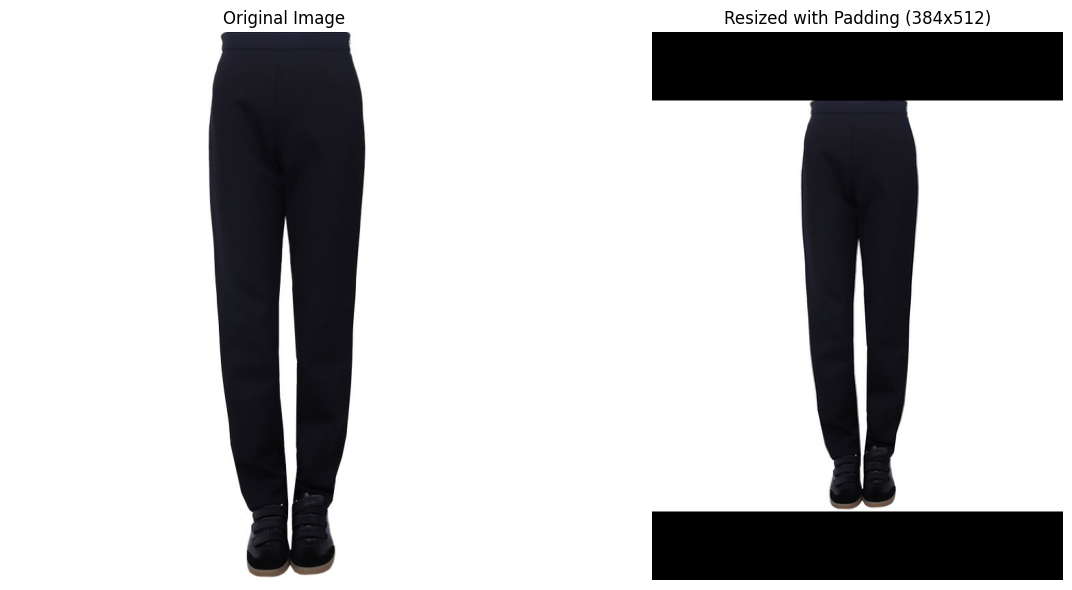

In [5]:
import matplotlib.pyplot as plt
from PIL import Image, ImageOps  # ImageOps를 추가로 임포트

# Modified display_images to include padding-based resize
def display_images_with_padding(original_image, resized_image_with_padding):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    axes[1].imshow(resized_image_with_padding)
    axes[1].set_title("Resized with Padding (384x512)")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()

# File path for the test image
file_path = "C:\\Users\\epdgn\\Downloads\\catvton_test\\trenbe\\test\\cloth\\bottom_68.jpg"

# Function for aspect ratio-respecting resize
def resize_with_aspect_ratio(image, target_width, target_height):
    """
    비율을 유지하며 리사이즈하고, 남는 공간은 패딩으로 채움.
    """
    # 원본 비율 계산
    aspect_ratio = image.width / image.height
    target_aspect_ratio = target_width / target_height

    # 비율에 따라 리사이즈
    if aspect_ratio > target_aspect_ratio:
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        new_height = target_height
        new_width = int(target_height * aspect_ratio)
    
    # 리사이즈된 이미지
    resized_image = image.resize((new_width, new_height), Image.LANCZOS)

    # 패딩 추가 (중앙 정렬)
    padded_image = ImageOps.pad(resized_image, (target_width, target_height), color=(0, 0, 0))
    return padded_image

try:
    # Load the original image
    original_image = Image.open(file_path)
    
    # Resize dimensions
    resize_width, resize_height = 384, 512

    # Resize the image with padding to maintain aspect ratio
    resized_image_with_padding = resize_with_aspect_ratio(original_image, resize_width, resize_height)

    # Display original and processed images
    display_images_with_padding(original_image, resized_image_with_padding)
except FileNotFoundError:
    print("The specified file was not found. Please check the file path again.")


In [ ]:
import os
import requests
import json
from io import BytesIO


# cloth 이미지를 다운받고 저장! 
# JSON 파일 경로
json_file_path = r"crawling/bottom.json"
with open(json_file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

output_dir = r"trenbe/test/cloth"

def download_and_save_image(url, save_path):
    try:
        # 이미지 다운로드 (스트림으로 처리)
        response = requests.get(url, stream=True)
        response.raise_for_status()  # HTTP 에러 확인
        
        # 메모리에서 이미지 열기
        img = Image.open(BytesIO(response.content)).convert("RGB")
        
        # JPG로 저장
        img.save(save_path, format="JPEG")
        print(f"Image saved at {save_path}")
    except requests.exceptions.RequestException as e:
        raise Exception(f"Failed to download image: {e}")
    except Exception as e:
        raise Exception(f"Error while processing image: {e}")

# 처리된 파일 저장
processed_files = set()

# 이미지 다운로드 및 저장
for category, items in data.items():
    for item in items:
        product_id = item["product_info"]["id"]
        for idx, style in enumerate(item["style_analysis"], start=1):
            image_url = style["image_url"]

            base_filename = os.path.splitext(os.path.basename(json_file_path))[0]
            filename = f"{base_filename}_{product_id}.jpg"  
            save_path = os.path.join(output_dir, filename)
            
            # 중복 방지
            if filename in processed_files:
                print(f"Skipped (duplicate): {filename}")
                continue 
            try:
                download_image(image_url, save_path)
                processed_files.add(filename)
            except Exception as e:
                print(f"Failed to download {filename}: {e}")

# 모델사진을 cloth 이름과 똑같이 저장
cloth_dir = "trenbe/test/cloth"  # cloth 디렉토리
image_dir = "trenbe/test/images"  # images 디렉토리

if os.path.exists(cloth_dir) and os.path.exists(image_dir):
    cloth_files = os.listdir(cloth_dir)  # cloth 디렉토리의 파일 목록
    image_files = os.listdir(image_dir)  # images 디렉토리의 파일 목록

    for cloth_file, image_file in zip(cloth_files, image_files):
        image_path = os.path.join(image_dir, image_file)
        
        new_image_name = os.path.splitext(cloth_file)[0] + ".jpg"  
        new_image_path = os.path.join(image_dir, new_image_name)
        
        os.rename(image_path, new_image_path)
        print(f"Renamed: {image_file} -> {new_image_name}")
else:
    print("Either cloth or images directory does not exist.")


# 똑같이 설정된 파일명을 바탕으로 txt 파일 생성 
cloth_dir = "trenbe/test/cloth"  # cloth 디렉토리
image_dir = "trenbe/test/images"  # images 디렉토리
output_file = "trenbe/test/test_pairs_paired.txt"  # 결과 파일 이름

# 파일 연결 생성
if os.path.exists(cloth_dir) and os.path.exists(image_dir):
    cloth_files = os.listdir(cloth_dir)  # cloth 디렉토리 파일 목록
    image_files = os.listdir(image_dir)  # images 디렉토리 파일 목록

    # test_pairs_unpaired.txt 생성
    with open(output_file, "w") as f:
        for image_file, cloth_file in zip(image_files, cloth_files):
            f.write(f"{image_file} {cloth_file}\n")
            print(f"Written pair: {image_file} {cloth_file}")

    print(f"File '{output_file}' created successfully.")
else:
    print("Either cloth or images directory does not exist.")



Downloaded: trenbe/test/cloth\bottom_1.jpg
Downloaded: trenbe/test/cloth\bottom_2.jpg
Downloaded: trenbe/test/cloth\bottom_3.jpg
Downloaded: trenbe/test/cloth\bottom_6.jpg
Downloaded: trenbe/test/cloth\bottom_7.jpg
Downloaded: trenbe/test/cloth\bottom_8.jpg
Downloaded: trenbe/test/cloth\bottom_12.jpg
Downloaded: trenbe/test/cloth\bottom_15.jpg
Downloaded: trenbe/test/cloth\bottom_16.jpg
Downloaded: trenbe/test/cloth\bottom_17.jpg
Downloaded: trenbe/test/cloth\bottom_20.jpg
Downloaded: trenbe/test/cloth\bottom_22.jpg
Downloaded: trenbe/test/cloth\bottom_23.jpg
Downloaded: trenbe/test/cloth\bottom_24.jpg
Downloaded: trenbe/test/cloth\bottom_26.jpg
Downloaded: trenbe/test/cloth\bottom_27.jpg
Downloaded: trenbe/test/cloth\bottom_30.jpg
Downloaded: trenbe/test/cloth\bottom_33.jpg
Downloaded: trenbe/test/cloth\bottom_36.jpg
Downloaded: trenbe/test/cloth\bottom_37.jpg
Downloaded: trenbe/test/cloth\bottom_39.jpg
Downloaded: trenbe/test/cloth\bottom_40.jpg
Downloaded: trenbe/test/cloth\bottom_4